# Extract sentiment vectors from text using NRC lexicon

In [13]:
import pensieve as pv
import pandas as pd
pd.options.display.max_rows = 6
import numpy as np
import re
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Read raw text
Seven books of Harry Potter in text format converted from rich text format.

Accessible by setting `book` to
+ book1.txt
+ ...
+ book7.txt

The raw text is read through `pv.Doc` and split into paragraph objects.

In [17]:
book = 'book1'
doc = pv.Doc('../../clusterpot/%s.txt' %book)
print("title: %s" %doc.paragraphs[0].text)

title: Harry Potter and the Sorcerer's Stone


## Read NRC lexicon
The NRC emotional lexicon is a curated list of words with
+ sentiments : positive and negative
+ emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, trust

Details of this work may be found at [Saif Mohammad's homepage](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)

The HDF5 file is cleaned from the original NRC text file.

The resulting pandas dataframe has the following columns
+ word | string
    + words in the lexicon
+ emo | string
    + the complete set of sentiments and emotion
+ binary | int
    + 0 if the word does not correspond to the sentiment or emotion
    + 1 if the word elicits the sentiment or emotion

In [14]:
df = pd.read_hdf('./NRC.h5')
df

,word,emo,binary
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
...,...,...,...
141817,zoom,sadness,0
141818,zoom,surprise,0
141819,zoom,trust,0


## Generate emotional vectors for every paragraph
+ for `p` in paragraphs in the text
    + tokenize the paragraph with `.split()`
    + initiate emotional vector `emo_d`
    + for every word (`w`) in paragraph (`p`)
        + strip special characters
        + query for word in NRC lexicon and read out the emo column with binary = 1
        + for every emotion (`e`)
            + if the word elicits an emotion in `emo_d`, then add 1 to the specified emotion.
    + append the emotion vectors to a list

In [35]:
emo_list = []
for p in tqdm(range(len(doc.paragraphs)), desc='par'):
    s = doc.paragraphs[p].text.split()
    emo_d = dict({'joy':0, 'fear':0, 'surprise':0, 'sadness':0, 'disgust':0, 'anger':0})
    for w in s:
        w = re.sub("[!@#$%^&*()_+:;,.\\?']", "", w)
        emo = df.query("word=='%s'" %w).query("binary==1")['emo'].as_matrix()
        for e in emo:
            if e in emo_d.keys():
                emo_d['%s' %e] += 1
            else:
                pass
    emo_list.append(emo_d)

## Write emotional vectors to HDF5
HDF5 is structured as
+ `bookn`
    + `len(doc.paragraphs)` x `len(emo_d.keys())` array of integers

where `n` spans 1 through 7.

In [51]:
pd.DataFrame(emo_list).to_hdf('./book_emo.h5',book)

# Read emo vectors in as HDF5 to analyse the text
Read in with corresponding text

In [20]:
rbook = 'book1'
doc = pv.Doc('../../clusterpot/%s.txt' %rbook)
book_emotions = pd.read_hdf('book_emo.h5',key=rbook)
book_emotions

,anger,disgust,fear,joy,sadness,surprise
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
...,...,...,...,...,...,...
3237,0,1,0,2,1,1
3238,0,0,0,2,0,2
3239,0,0,0,0,0,0


## Simple example: choose emotion to sort by
Choose `emo_kw` from list `['anger', disgust', 'fear', 'joy', 'sadness', 'surprise']`

In [25]:
emo_kw = 'anger'
emo_rank = np.argsort(book_emotions[emo_kw].as_matrix())[::-1]
emo_rank

array([ 522, 2645, 3036, ..., 2037, 2036,    0])

## Print the paragraph and emotional vector corresponding to the n-th highest sorted paragraph

`pidx` | int
+ starts from 0, chooses the paragraph correponding to the pidx-th highest sorted paragraph

In [27]:
pidx = 1
print(doc.paragraphs[emo_rank[pidx]].text)
book_emotions.iloc[emo_rank[pidx]]

"That is because it is a monstrous thing, to slay a unicorn," said Firenze. "Only one who has nothing to lose, and everything to gain, would commit such a crime. The blood of a unicorn will keep you alive, even if you are an inch from death, but at a terrible price. You have slain something pure and defenseless to save yourself, and you will have but a half-life, a cursed life, from the moment the blood touches your lips."


anger       6
disgust     3
fear        5
joy         3
sadness     5
surprise    2
Name: 2645, dtype: int64

## Plot emotional vectors
Plots emotional vectors

`rescale` | boolean
    + True rescales the vectors with paragraph length.

/Users/cchang5/anaconda/envs/cdips2017/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/cchang5/anaconda/envs/cdips2017/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/cchang5/anaconda/envs/cdips2017/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>


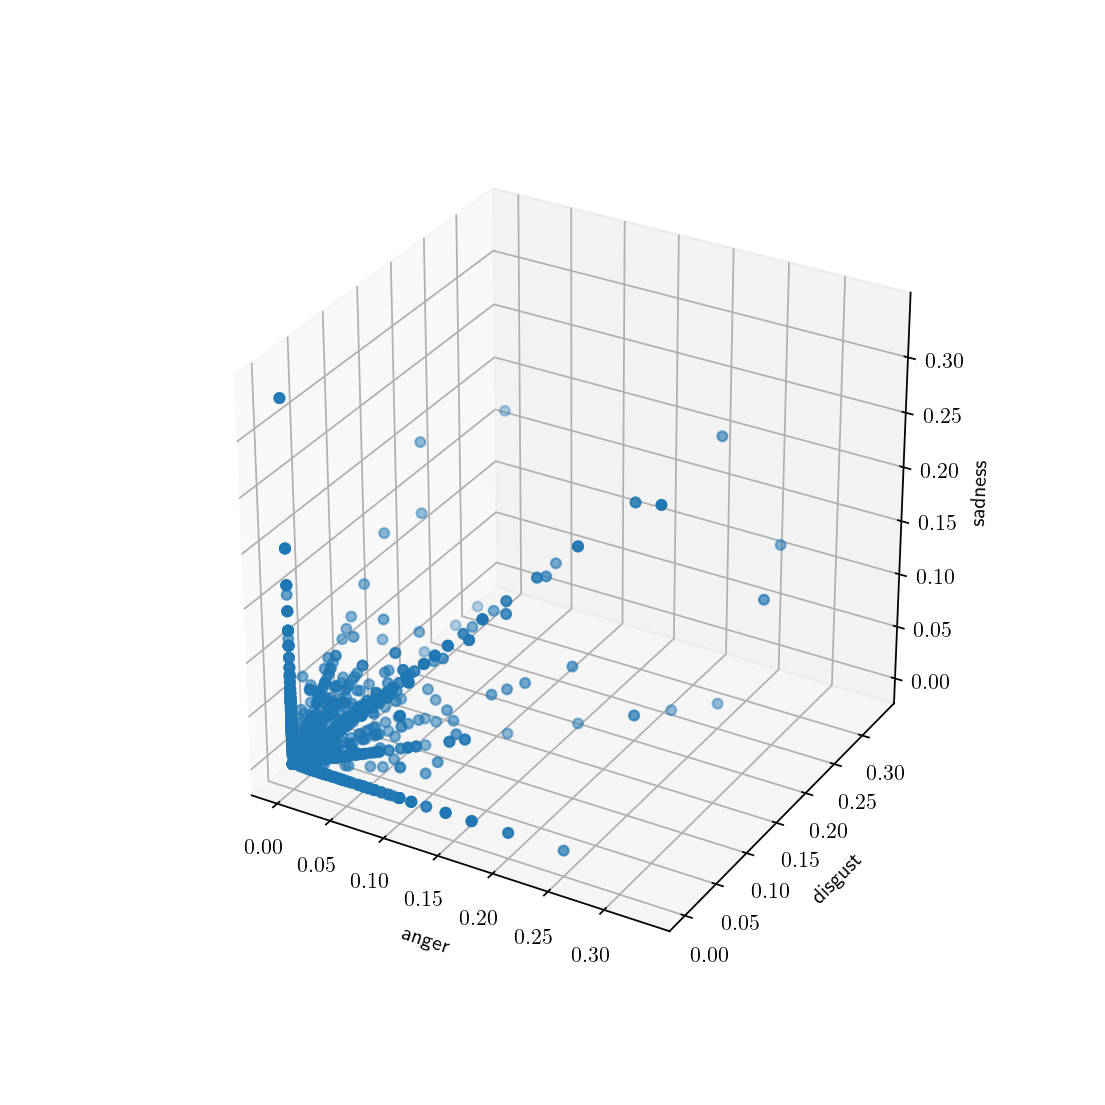

In [29]:
rescale = True
if rescale:
    slength = [float(len(doc.paragraphs[i].text.split())) for i in range(len(doc.paragraphs))]
else:
    slength = 1
x = book_emotions['anger'].as_matrix()/slength
y = book_emotions['disgust'].as_matrix()/slength
z = book_emotions['sadness'].as_matrix()/slength
fig = plt.figure('emotional correlation',figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x,ys=y,zs=z)
ax.set_xlabel('anger')
ax.set_ylabel('disgust')
ax.set_zlabel('sadness')
plt.draw()
plt.show()

# Test code

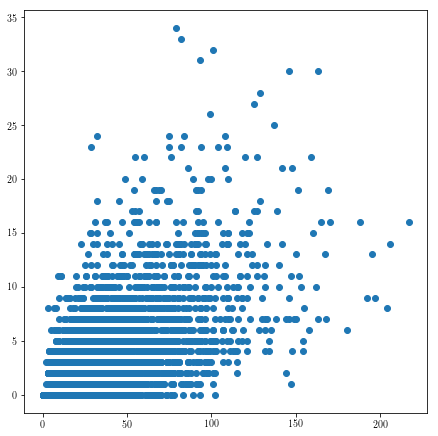

In [123]:
slength = [float(len(doc.paragraphs[i].text.split())) for i in range(len(doc.paragraphs))]
y = np.sum(book_emotions.as_matrix(),axis=1)
plt.figure('paragraph length vs. emotion sum',figsize=(7,7))
ax = plt.axes([0.15,0.15,0.8,0.8])
ax.scatter(x=slength,y=y)
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
#ax.set_xscale('log')
plt.draw()
plt.show()

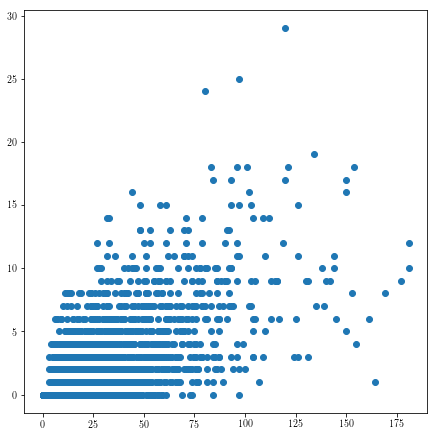

In [126]:
slength = [float(len(doc.paragraphs[i].text.split())) for i in range(len(doc.paragraphs))]
y = np.sum(book_emotions.as_matrix(),axis=1)
plt.figure('paragraph length vs. emotion sum',figsize=(7,7))
ax = plt.axes([0.15,0.15,0.8,0.8])
ax.scatter(x=slength,y=y)
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
#ax.set_xscale('log')
plt.draw()
plt.show()

In [34]:
s = "Upon the signature of the International Statute of Secrecy in 1689, wizards went into hiding for good. It was natural, perhaps, that they formed their own small communities within a community. Many small villages and hamlets attracted several magical families, who banded together for mutual support and protection. The villages of Tinworsh in Cornwall, Upper Flagley in Yorkshire, and Ottery St. Catchpole on the south coast of England were notable homes to knots of Wizarding families who lived alongside tolerant and sometimes Confunded Muggles. Most celebrated of these half-magical dwelling places is, perhaps, Godrics Hollow, the West Country village where the great wizard Godric Gryffindor was born, and where Bowman Wright, Wizarding smith, forged the first Golden Snitch. The graveyard is full of the names of ancient magical families, and this accounts, no doubt, for the stories of hauntings that have dogged the little church beside it for many centuries."
w = s.split()[0]
%timeit re.sub("[!@#$%^&*()_+:;,.\\?']", "", w)


The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.04 µs per loop


In [33]:
%%timeit
punctuation = ["!","@","#","$","%","^","&","*","(",")","_","+",":",";",",",".","?","'","\\"]
for punc in punctuation:
    w.replace("%s" %punc,'')

100000 loops, best of 3: 4.67 µs per loop
